In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import cvxpy as cp

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

# part 1

(a) Let n be the total number of pixels, and let k be the total number of 1s. What is k/n?
Recall that compressive sensing only works when the image is sparse, so we’re hoping k/n is much
less than 1.

In [2]:
f_data = pd.read_csv('p9_images/wonderland-tree.txt', header = None).values

In [3]:
data = np.zeros((40,30))
for i in range(40):
    for j in range(30):
        data[i][j] = int(f_data[i][0][j])

In [4]:
k = np.sum(data == 1)
n = 40 * 30
k / n

0.20999999999999999

(b) Fix a 1200 × 1200 matrix A of independently chosen N (0, 1) Gaussians. Let $A_r$ denote
the first r rows of A. Let x be the image wonderland-tree as a vector of 1200 pixels. Our
compressed image is going to be $b_r = A_rx$.
Based on Lecture #18, write a linear program that recovers an approximation $x_r$ to x from $b_r$,
and verify using numpy.allclose() that $x_{600} = x$ up to numerical precision (i.e., the recovery is
exact).


[Hint: You’ll get better results if you add constraints like x ≥ 0 into your linear program. The
staff implementation takes 5-20 seconds on a laptop, depending on the implementation, so if your
program is taking ten minutes you likely have an error.]

The example code in the Vectors and Matrices section at http://www.cvxpy.org/en/latest/tutorial/intro/index.html has all the cvxpy commands you should need.

In [5]:
if not os.path.exists('A.npy'):
    A = np.random.randn(600,1200)
    np.save('A.npy', A)
else:
    A = np.load('A.npy')

In [6]:
x = data.reshape(-1)
x.shape
A.shape

(1200,)

(600, 1200)

In [7]:
b = A @ x
b.shape

(600,)

In [8]:
x_hat = cp.Variable(n)
objective = cp.Minimize(cp.sum(x_hat))
constraints = [0 <= x_hat, A*x_hat == b]
prob = cp.Problem(objective, constraints)
# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal value for x is stored in `x.value`.
print(x_hat.value)
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
# print(constraints[0].dual_value)

[  1.22116399e-07   6.14298215e-07   3.01360314e-06 ...,  -7.42666826e-07
   1.39444889e-06   1.19109184e-07]


In [9]:
np.allclose(x_hat.value,x)
np.max(np.abs(x_hat.value - x))

False

2.4019555965315575e-05

(c) Let $r^∗$ be the smallest r such that $||x − x_r||_1 < .001$ (i.e., $x = x_r$, up to numerical
precision errors). Find $r^∗$
.
[Hint 1: Do not use numpy.allclose() with the default parameters; the numerical errors here
are larger. Hint 2: Use binary search.]

In [10]:
left, right = 0, 600
while(left < right):
    middle = int(np.ceil((left + right)/2))
    b = A[:middle] @ x
    x_hat = cp.Variable(n)
    objective = cp.Minimize(cp.sum(x_hat))
    constraints = [0 <= x_hat, A[:middle]*x_hat == b]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    if np.max(np.abs(x_hat.value - x)) < 0.001:
        if right == middle:
            print('r* = ', right)
            break
        else:
            right = middle
    else:
        if left == middle:
            print('r* = ', left)
            break
        else:
            left = middle
    print('[%d,%d]' %(left, right))

[300,600]
[450,600]
[450,525]
[450,488]
[469,488]
[469,479]
[474,479]
[477,479]
[478,479]
r* =  479


(d) Plot $||x_i − x||_1$ for $i = [r^∗ − 10, r^∗ − 9, r^∗ − 8, . . . , r^∗ − 1, r^∗, r^∗ + 1, r^∗ + 2]$. You should
see a sharp drop-of

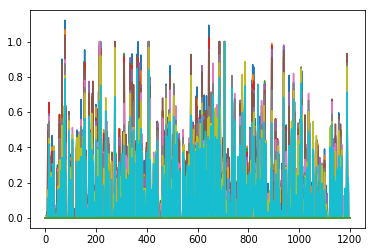

In [11]:
for i in range(-10,3):
    b = A[:479+i] @ x
    x_hat = cp.Variable(n)
    objective = cp.Minimize(cp.sum(x_hat))
    constraints = [0 <= x_hat, A[:479+i]*x_hat == b]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    plt.plot(np.arange(len(x)), np.abs(x_hat.value - x))
plt.show();

# part 2

(a) The following code is the mask we will use to separate the good pixels from the
corrupted ones.

In [12]:
from PIL import Image
from numpy import array
img = array(Image.open("p9_images/corrupted.png"), dtype=int)[:,:,0]
Known = (img > 0).astype(int)

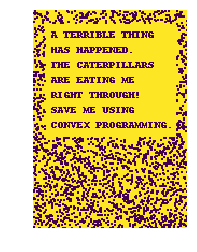

In [13]:
plt.imshow(Known)
plt.axis('off')
plt.show();

(b) We will first explore a naive solution for image reconstruction. For every pixel in img
that is 0 (unknown), replace it with the average of its (up to 4) known neighbors’ pixels. If there
are no known neighbors, then keep the pixel value of 0. Submit your recovered image and a 2-3
sentence explanation for why the naive solution performs poorly and how you might improve it.

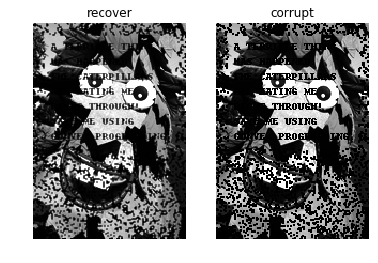

In [14]:
row, col = img.shape
recover = np.zeros(img.shape)

for i in range(row):
    if Known[i][0]:
        recover[i][0] = img[i][0]
    if Known[i][col-1]:
        recover[i][col-1] = img[i][col-1]

for i in range(col):
    if Known[0][i]:
        recover[0][i] = img[0][i]
    if Known[row-1][i]:
        recover[row-1][i] = img[row-1][i]
        

for i in range(1,row-1):
    for j in range(1,col-1):
        if not Known[i][j]:
            recover[i][j] = (img[i][j+1] + img[i+1][j] + img[i-1][j] + img[i][j-1])/4
        else:
            recover[i][j] = img[i][j]
            
plt.subplot(121), plt.title('recover')
plt.imshow(recover, cmap = 'gray')
plt.axis('off')
plt.subplot(122), plt.title('corrupt')
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show();

<font color='blue'> Using average method could not totally recover the image since it acts as a filter that just smooth the black pixel which means that if some pixel are connected with each other(i.e. four connected), it is hardly to recover the center black pixel. To better recover the image, we could construct a convex problem which has an influence on the center pixel and then approximate it consequently.

(c) The following code should reconstruct our mascot! (You may want to look up what the
function tv does here: http://nbviewer.jupyter.org/github/cvxgrp/cvxpy/blob/master/examples/notebooks/WWW/tv_inpainting.ipynb)

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 163764, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 57713, constraints m = 115081
Cones:	primal zero / dual free vars: 29029
	soc vars: 86052, soc blks: 28684
Setup time: 1.09e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.01e+00  3.39e+00  1.00e+00 -8.01e+06  1.84e+06  2.09e-09  1.26e-01 
   100| 1.03e-03  1.17e-03  2.97e-05  7.52e+05  7.52e+05  2.97e-10  5.54e+00 
   200| 1.09e-04  1.35e-04  1.19e-

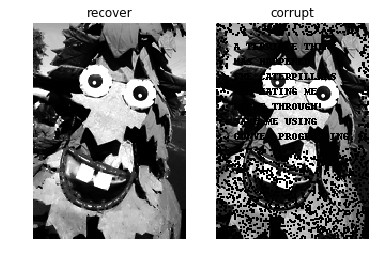

In [15]:
from cvxpy import Variable, Minimize, Problem, multiply, tv
U = Variable(shape = img.shape)
obj = Minimize(tv(U))
constraints = [multiply(Known, U) == multiply(Known, img)]
prob = Problem(obj, constraints)
prob.solve(verbose=True)
# recovered image is now in U.value
plt.subplot(121), plt.title('recover')
plt.imshow(U.value, cmap = 'gray')
plt.axis('off')
plt.subplot(122), plt.title('corrupt')
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show();

(d) Give a 2-3 sentence explanation for why it makes sense, conceptually, to use the $l_2$
norm (as opposed to the $l_1$ norm) for recovering a corrupted image?

<font color='blue'> In order to recover the image, we need to add some assumption. We know that the image could act as a matrix. The key assumption we make here is that the origin matrix has low rank. Also, the matrix is sufficiently dense and non-pathological. After these assumption, we cold construct an convex optimize problem and get a good approximiation of the origin image. Note that $l_2$ norm is more make sense than $l_1$ since $l_1$ norm prefers to sparse solution which means it wanna the difference between the neighor pixels are zero and it also could hardly recover the center black pixel in four connected zone.